In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon
from pyproj import Proj

plt.rcParams["font.family"] = "Times New Roman"

In [17]:
# read italian regions shapes
ita = gpd.read_file("italian-maps-shapefiles/italy-with-regions/reg2011_g.shp")

# get lombardia
lmb = ita[ita["NOME_REG"]=="LOMBARDIA"]

# get lombardia with provinces shape
lmb_p = gpd.read_file("italian-maps-shapefiles/regions-with-provinces/lombardia/lombardia.shp")

# add number of intervention per pronvince
lmb_p["interventi"] = [0,5,14,4,0,0,0,0,0,3,3,2]

In [22]:
# init converter (from lat, ln to utm)
pp = Proj(proj='utm', zone=32, ellps='WGS84', preserve_units=True)

# inti cities where interventions took place
cities = pd.DataFrame({
    "city":["Caponago","Lecco", "Linate","Mantova","Meda","Monza", "Pavia", "Vigevano","Voghera"],
    "lat":[45.5668,45.8566,45.4522,45.1564,45.6611,45.5845,45.1847,45.3155,44.9917],
    "lng":[9.3769,9.3977,9.2763,10.7914,9.1524,9.2744,9.1582,8.8355,9.0120],
    "annot_offset":[
        (5000,-2000),(5000,-2000),(5000,-2000),
        (1500,-11000),(3000,3000),(4000,3800),
        (5000,-2000),(5000,-2000),(3000,2000)]
})

# add utms
cities = pd.concat([
    cities,
    cities.apply(lambda x: pp(x.lng, x.lat), axis=1).apply(pd.Series)
], axis=1)

# rename columns
cities = cities.rename(columns={0:"utm_e",1:"utm_n"})

# get geo data
cities_geo = gpd.GeoDataFrame(cities, geometry=gpd.points_from_xy(cities.utm_e, cities.utm_n))

# show
cities_geo

,city,lat,lng,annot_offset,utm_e,utm_n,geometry
0,Caponago,45.5668,9.3769,"(5000, -2000)",529411.147428,5.045987e+06,POINT (529411.147 5045986.910)
1,Lecco,45.8566,9.3977,"(5000, -2000)",530874.280042,5.078192e+06,POINT (530874.280 5078191.862)
2,Linate,45.4522,9.2763,"(5000, -2000)",521604.691693,5.033223e+06,POINT (521604.692 5033223.211)
3,Mantova,45.1564,10.7914,"(1500, -11000)",640804.991889,5.001886e+06,POINT (640804.992 5001885.673)
4,Meda,45.6611,9.1524,"(3000, 3000)",511872.521833,5.056406e+06,POINT (511872.522 5056405.793)
5,Monza,45.5845,9.2744,"(4000, 3800)",521405.901710,5.047921e+06,POINT (521405.902 5047920.892)
6,Pavia,45.1847,9.1582,"(5000, -2000)",512428.455645,5.003481e+06,POINT (512428.456 5003480.734)
7,Vigevano,45.3155,8.8355,"(5000, -2000)",487106.234262,5.018013e+06,POINT (487106.234 5018012.583)
8,Voghera,44.9917,9.0120,"(3000, 2000)",500945.920095,4.982028e+06,POINT (500945.920 4982028.446)


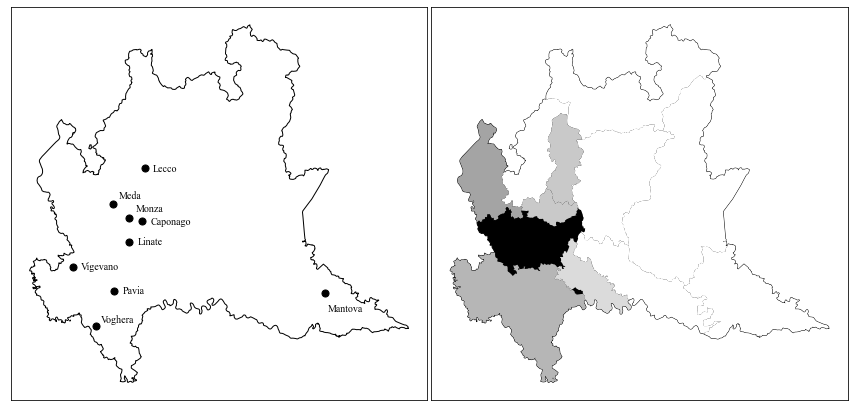

In [21]:
fig,(ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,15))

# plot lombardia without provinces
lmb.plot(facecolor="#fff", edgecolor="#000", ax=ax1)

# plot lombardia without provinces, plot cities (with text)
lmb_p.plot(facecolor="#fff", edgecolor="#000", ax=ax2)
cities_geo.plot(marker="o", markersize=50, color="#000", ax=ax1)
for idx, row in cities_geo.iterrows():
    ax1.annotate(row.city, (row.utm_e + row.annot_offset[0], row.utm_n + row.annot_offset[1]))

# cloropleth of interventions
lmb_p.plot(column='interventi', cmap='gray_r', ax=ax2)

# customize axes
for ax in (ax1,ax2):
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

# reduce horizontal space
fig.subplots_adjust(wspace=0.01)

# save
plt.savefig("geografia interventi.pdf", bbox_inches='tight',pad_inches=0)